# 📊 Анализ A/B-теста: подготовка, исследование и проверка гипотез

В данном проекте будут произведены предобработка и анализ данных A/B-теста, включая проверку влияния тестируемого изменения на ключевые метрики: время в игре (gametime) и доход (revenue).
Мы сравним показатели тестовой и контрольной групп и определим, являются ли выявленные различия значимыми с точки зрения статистики.

### Входные данные
Данные для анализа - **test_dataset.csv**

Где:

**- Group** – группа (Control или Test)

**- user_id** – идентификатор пользователя

**- timestamp** – дата события

**- regdate** – дата регистрации

**- traffic_type** – тип трафика (Paid или Organic)

**- gametime** – игровое время 

**- revenue** – доход

## 1️⃣ Импорт библиотек

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 2️⃣ Загрузка и предварительное исследование данных

Загружаем датасет, сразу же преобразовав столбцы с датами в формат datetime и изучаем его структуру:

In [226]:
df = pd.read_csv("/Users/Alena/Desktop/test_dataset.csv", encoding='utf-8', sep=';', parse_dates = ['timestamp', 'regdate'], dayfirst = True)

In [227]:
#Просмотр первых строк
df.head(10)

,Group,user_id,timestamp,regdate,traffic_type,gametime,revenue
0,Control,4e6550edc89y13d2014faf599444812c92df6924,2021-04-01,2021-02-24,Paid,215886.0,0.0
1,Test,1e28f7e4y158dc8323ecfae71d14acf2ce92821c,2021-04-01,2019-09-08,Organic,1699057.0,0.0
2,Control,ey003daf052a6c1d6a34854d4e63afc763601a6a,2021-03-27,2020-01-07,Organic,360667.0,0.0
3,Control,f903436f2y7cey67e89d009c4892154034ay1d3y,2021-03-25,2021-02-08,Paid,159227.0,0.0
4,Control,347f873ca5ea26dea2347232c1282097d12dc4c0,2021-03-20,2020-10-28,Paid,846950.0,0.0
5,Test,y613281fcda861y8c9e1a8a9d732d5ecae8dd15y,2021-03-31,2020-03-20,Organic,292904.0,0.0
6,Test,7685a40yday17e2fd02a6a1fad642596y6805121,2021-03-31,2021-03-24,Paid,30892.0,0.0
7,Control,y73y1e931a3769c583ca937dd66c4aef4d6e31cd,2021-03-19,2020-12-28,Paid,100394.0,0.0
8,Control,7f70yedd1y1721yf437e6cdydae522c2ead698f8,2021-03-24,2020-04-01,Paid,402302.0,0.0
9,Control,262d77645124de79960ca588c8y6fa0f762422a3,2021-04-08,2021-03-22,Organic,18568.0,0.0


In [230]:
#Общая информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703809 entries, 0 to 703808
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Group         703809 non-null  object        
 1   user_id       703809 non-null  object        
 2   timestamp     703809 non-null  datetime64[ns]
 3   regdate       703809 non-null  datetime64[ns]
 4   traffic_type  703809 non-null  object        
 5   gametime      696919 non-null  float64       
 6   revenue       703809 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 37.6+ MB


In [232]:
#Проверка на пропущенные значения
df.isnull().sum()

Group              0
user_id            0
timestamp          0
regdate            0
traffic_type       0
gametime        6890
revenue            0
dtype: int64

## 3️⃣ Предобработка данных

**3.1 Удаление дубликатов**

In [236]:
#Смотрим кол-во дубликатов
df.duplicated().sum()


1

In [238]:
#Удаляем дубликат
df = df.drop_duplicates()

#Проверяем кол-во оставшихся строк
len(df)

703808

**3.2 Заполнение пропусков в столбце gametime**

In [241]:
#Для заполнения пропусков используем медиану, чтобы не искажать распределение данных
df['gametime'] = df['gametime'].fillna(df['gametime'].median())

#Проверка на пропущенные значения
df.isnull().sum()

Group           0
user_id         0
timestamp       0
regdate         0
traffic_type    0
gametime        0
revenue         0
dtype: int64

**3.3 Проверка и удаление аномалий**

In [244]:
#Удаляем некорректные значения (отрицательный доход и игровое время)
df = df[(df['revenue'] >= 0) & (df['gametime'] >= 0)]

#Проверяем кол-во оставшихся строк
len(df)

701251

## 4️⃣ Разведочный анализ данных (EDA)
**4.1. Проверка баланса групп**

Перед анализом нужно убедиться, что группы сбалансированы:

In [247]:
#Если распределение очень неравномерное, результаты A/B-теста могут быть некорректными
df['Group'].value_counts(normalize=True) * 100

Group
Control    80.085875
Test       19.914125
Name: proportion, dtype: float64

In [249]:
#Проверим как распределены данные в тестовой и контрольной группах
df.groupby('Group')[['gametime', 'revenue']].describe()

gametime                                                        \
            count          mean           std   min       25%       50%   
Group                                                                     
Control  561603.0  6.352833e+06  9.356194e+07   6.0  34734.50  172959.0   
Test     139648.0  6.695861e+06  9.658437e+07  13.0  34812.75  172959.0   

                                  revenue                                     \
              75%           max     count      mean       std  min  25%  50%   
Group                                                                          
Control  502599.5  2.139124e+09  561603.0  0.137810  2.295041  0.0  0.0  0.0   
Test     522078.5  2.138080e+09  139648.0  0.143555  3.120181  0.0  0.0  0.0   

                          
         75%         max  
Group                     
Control  0.0  790.427347  
Test     0.0  820.246603

⚠️ В идеале, для корректного проведения A/B теста группы должны быть примерно одинаковыми по размеру, чтобы результаты теста были достоверными. В данном случае контрольная группа значительно больше, чем тестовая, что может привести к искажению результатов, если не будет учтено при анализе.

Поэтому необходимо сбалансировать группы. Используем для этого сэмплинг, чтобы обе группы имели более равное количество участников.

**4.2 Выравнивание количества записей между группами**

Чтобы контрольная и тестовая группы имели одинаковое количество строк, выберем случайную подвыборку из большей группы, чтобы она соответствовала размеру меньшей:

In [252]:
# Делаем случайную выборку из обеих групп до минимального размера
df_control_sampled = df_control.sample(n=min_size, random_state=42)
df_test_sampled = df_test.sample(n=min_size, random_state=42)

# Объединяем обратно в общий DataFrame
df_balanced = pd.concat([df_control_sampled, df_test_sampled])

# Проверяем баланс после сэмплинга
print(df_balanced['Group'].value_counts(normalize=True) * 100)


Group
Control    50.0
Test       50.0
Name: proportion, dtype: float64


In [254]:
df_balanced

,Group,user_id,timestamp,regdate,traffic_type,gametime,revenue
639634,Control,e5d7y8ce5d132yy7cec3871167fy990cd7fyf5fy,2021-03-28,2020-01-17,Paid,1.121217e+06,0.0
77459,Control,2896f3259932630cca1947ded9ac5f5afdf1c9c5,2021-03-27,2020-08-26,Organic,2.937840e+05,0.0
561251,Control,7145ec43y08f9c83d5472205a3fc4797y108y144,2021-03-18,2020-04-27,Organic,9.333430e+05,0.0
441074,Control,09794fd782y07y61f831a8yd4c5cy5y4685480a3,2021-03-28,2020-12-29,Organic,2.442060e+05,0.0
295281,Control,1849a64yc1d24cd0c259902446f00140yyfd9c14,2021-04-05,2020-04-20,Organic,9.534670e+05,0.0
...,...,...,...,...,...,...,...
556422,Test,cyd5602e49f4a39d82ef28yef0c4a9f560639afd,2021-04-06,2020-07-19,Paid,1.094463e+09,0.0
604656,Test,d02d928yf6c39f9f7d7y52c5d604e324a6ad3d8a,2021-04-02,2020-03-30,Paid,2.923226e+08,0.0
522735,Test,54yf5523y5681052c260a10618497cyyy44y4faf,2021-04-01,2021-03-28,Paid,5.230000e+03,0.0
664204,Test,6847ce6d58fdcc9f8aa7a6y09a52y01cfffd3y26,2021-03-20,2021-03-14,Paid,2.147500e+04,0.0


In [256]:
#Проверим как распределены данные в тестовой и контрольной группах в сбалансированном датасете
df_balanced.groupby('Group')[['gametime', 'revenue']].describe()

gametime                                                        \
            count          mean           std   min       25%       50%   
Group                                                                     
Control  139648.0  6.630572e+06  9.550834e+07  10.0  34940.50  172959.0   
Test     139648.0  6.695861e+06  9.658437e+07  13.0  34812.75  172959.0   

                                   revenue                                     \
               75%           max     count      mean       std  min  25%  50%   
Group                                                                           
Control  500509.25  2.138409e+09  139648.0  0.143961  2.061780  0.0  0.0  0.0   
Test     522078.50  2.138080e+09  139648.0  0.143555  3.120181  0.0  0.0  0.0   

                          
         75%         max  
Group                     
Control  0.0  207.619039  
Test     0.0  820.246603

In [302]:
#Проверим и сравним средние показали по revenue и gametime между первоначальным датасетом (df) и новым (df_balanced)

#Среднее время в игре (сбалансированный датасет)
df_balanced.groupby(['Group'])\
           .agg({'gametime':'mean'})

,gametime
Group,
Control,6.630572e+06
Test,6.695861e+06


In [306]:
#Среднее время в игре (первоначальный датасет)
df.groupby(['Group'])\
           .agg({'gametime':'mean'})

,gametime
Group,
Control,6.352833e+06
Test,6.695861e+06


In [308]:
#Средний доход (сбалансированный датасет)
df_balanced.groupby(['Group'])\
           .agg({'revenue':'mean'})

,revenue
Group,
Control,0.143961
Test,0.143555


In [310]:
#Средний доход (первоначальный датасет)
df.groupby(['Group'])\
           .agg({'revenue':'mean'})

,revenue
Group,
Control,0.137810
Test,0.143555


**Вывод:** не смотря на то, что первоначальный датасет был сбалансирован и кол-во данных по контрольной группе уменьшено - это не повлияло на средние величины метрик.

## 5️⃣ Статистический анализ тестовой и контрольной группы

In [261]:
#Посчитаем и отобразим на графике выручку по группам
total_revenue = df_balanced.groupby(['Group'])\
           .agg({'revenue':'sum'}).round(2)
print(total_revenue)

          revenue
Group            
Control  20103.83
Test     20047.18


<Axes: xlabel='Group', ylabel='revenue'>

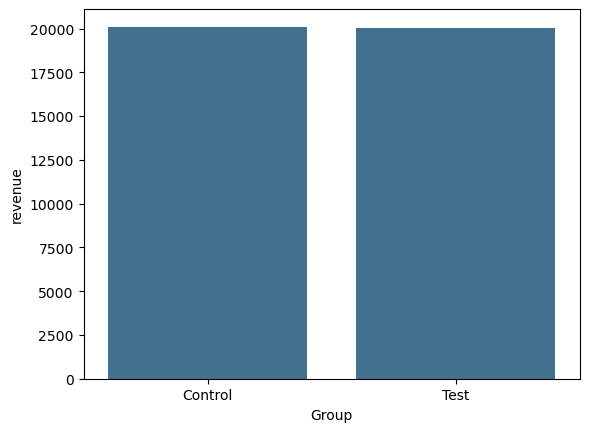

In [265]:
sns.barplot(x = 'Group', y = 'revenue', data = total_revenue, saturation = 0.5)

**Вывод:**
доход (revenue) в тестовой (Test) и контрольной (Control) группах практически одинаков: разница всего 56.65 – это менее 0.3%, что можно считать незначительным изменением.

In [276]:
#Посчитаем и отобразим на графике общее время, проведенное в игре по группам

total_gametime = df_balanced.groupby(['Group'])\
           .agg({'gametime':'sum'}).round(2)
print(total_gametime)

             gametime
Group                
Control  9.259462e+11
Test     9.350636e+11


<Axes: xlabel='Group', ylabel='gametime'>

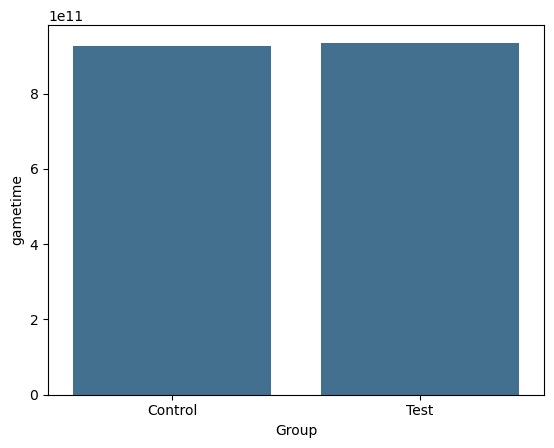

In [278]:
sns.barplot(x = 'Group', y = 'gametime', data = total_gametime, saturation = 0.5)

**Вывод:** разница небольшая – нужно проверить статистическую значимость.

## 6️⃣ Проверка нормальности распределения

***Проведем тест Шапиро-Уилка на нормальность для gametime в контрольной группе.***

In [328]:
stats.shapiro(df_balanced[df_balanced["Group"] == "Control"]["gametime"].sample(5000, random_state=42)) 


ShapiroResult(statistic=0.038262231595894924, pvalue=6.248864242096753e-95)

### 📊 Разбор результата:

1️⃣ **statistic** = 0.038 - это коэффициент Шапиро-Уилка. Если он близок к 1, то данные похожи на нормальные.

У нас 0.038, что очень далеко от 1 → вероятно, распределение сильно отличается от нормального.

2️⃣ **p-value** = 6.25 × 10⁻⁹⁵ 

У нас p-value ≈ 0 → мы отвергаем гипотезу нормальности.

📌 Вывод:
gametime в контрольной группе НЕ распределен нормально!

**Необходимо использовать непараметрический тест.**


***Проведем тест Шапиро-Уилка на нормальность для gametime в тестовой группе.***

In [336]:
stats.shapiro(df_balanced[df_balanced["Group"] == "Test"]["gametime"].sample(5000, random_state=42)) 


ShapiroResult(statistic=0.039436589141827016, pvalue=6.677294448037204e-95)

📌 Вывод: gametime в тестовой группе НЕ распределен нормально!

**Необходимо использовать непараметрический тест.**

## 7️⃣ Статистический тест: проверяем разницу между группами

Если данные не нормальны, используем критерий Манна-Уитни:

In [147]:
stat, p = stats.mannwhitneyu(df_balanced[df_balanced["Group"] == "Test"]["gametime"], 
                             df_balanced[df_balanced["Group"] == "Control"]["gametime"], 
                             alternative='two-sided')

print(f"U-статистика: {stat}, p-value: {p}")



if p < 0.05:
    print("Разница между группами статистически значима! 🎉")
else:
    print("Разницы нет, тестируемое изменение не оказало эффекта. 😕")


U-статистика: 9781480968.5, p-value: 0.14960019665594124
Разницы нет, тестируемое изменение не оказало эффекта. 😕


In [149]:
stat, p = stats.mannwhitneyu(df_balanced[df_balanced["Group"] == "Test"]["revenue"], 
                             df_balanced[df_balanced["Group"] == "Control"]["revenue"], 
                             alternative='two-sided')

print(f"U-статистика: {stat}, p-value: {p}")

if p < 0.05:
    print("Разница между группами статистически значима! 🎉")
else:
    print("Разницы нет, тестируемое изменение не оказало эффекта. 😕")

U-статистика: 9743944630.5, p-value: 0.060767823093768145
Разницы нет, тестируемое изменение не оказало эффекта. 😕


## 📊 Вывод по A/B-тесту (gametime и revenue)
Мы провели тест Манна-Уитни для двух метрик: время игры (gametime) и доход (revenue)

📌 Результат:

✅ Разницы нет → тестируемое изменение НЕ оказало статистически значимого эффекта ни на gametime, ни на revenue.



### 🔍 Что это значит?
1️⃣ Изменение не повлияло на ключевые метрики. 
- Пользователи играли примерно столько же, сколько и раньше.
- Доход также остался на прежнем уровне.
- Разница между группами могла быть случайной флуктуацией.

2️⃣ Гипотеза об улучшении gametime и revenue не подтвердилась.

Возможно, изменение не имеет значимого влияния на поведение пользователей.

3️⃣ Возможные причины отсутствия эффекта:
- Не то изменение → пользователи просто не реагируют на тестируемый фактор.
- Другие внешние факторы → например, сезонность или маркетинговые кампании могли повлиять на поведение.
- Высокая вариативность revenue → доход может сильно колебаться из-за редких, но крупных покупок, и тест Манна-Уитни может их не учитывать.